In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

from scipy import stats
from scipy.stats import norm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import itertools

In [10]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images_12": "image_index",
    "natural_images": "image_index"
               }
multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images_12": "natural_images",
        "natural_images": "natural_images_12",
    }

In [11]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

## SUPPLEMENTARY FIGURE 4A

In [12]:
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

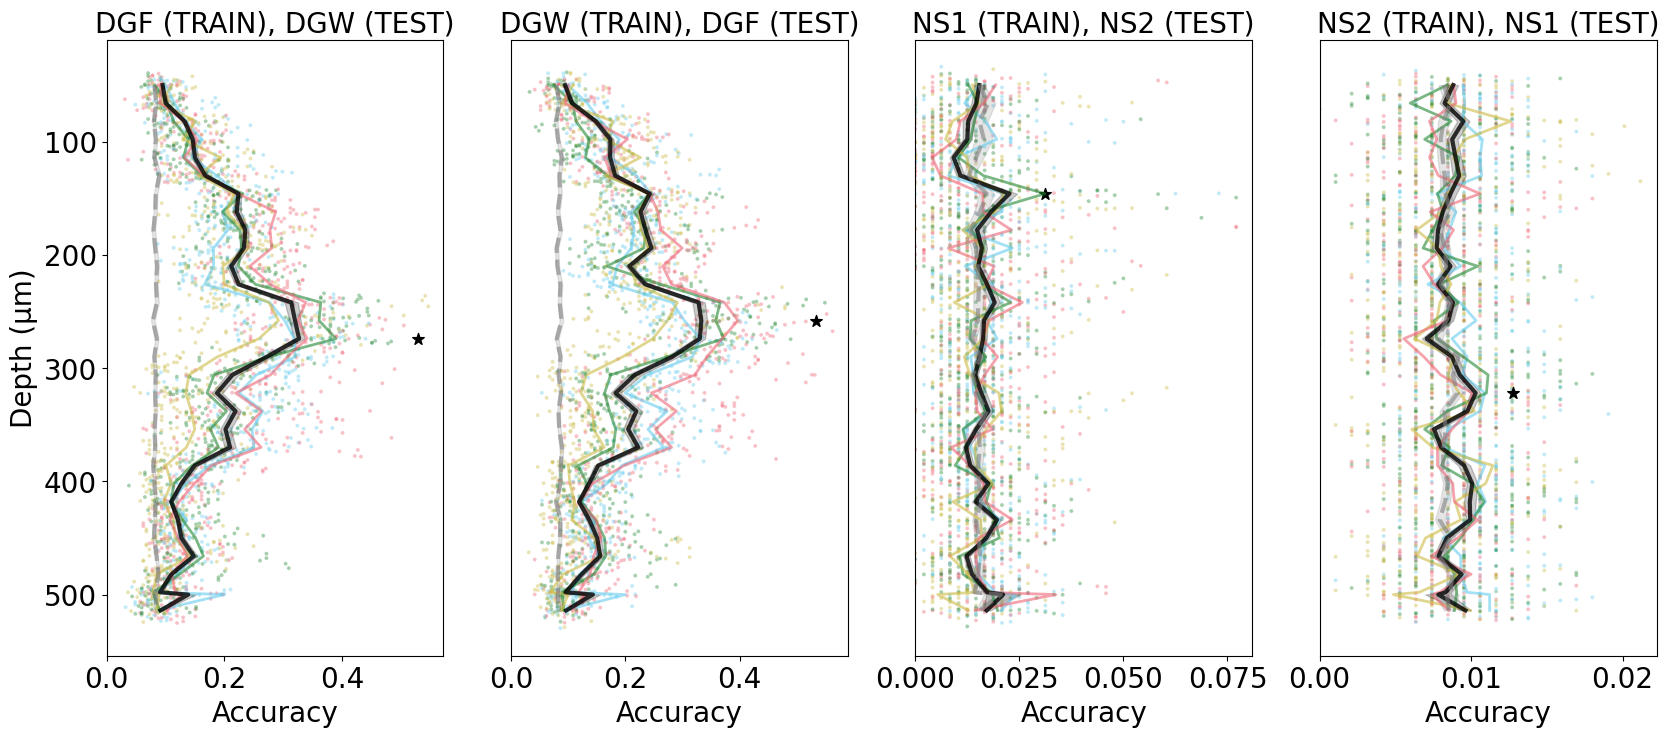

In [13]:
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
jitter_amount = 5
n_stims = 4
titles = [
    'DGF (TRAIN), DGW (TEST)',
    'DGW (TRAIN), DGF (TEST)',
    'NS1 (TRAIN), NS2 (TEST)',
    'NS2 (TRAIN), NS1 (TEST)'
]

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df = temp_df.explode('test_accuracy')

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False
    )

    sns.lineplot(data=temp_df, 
                    x='test_accuracy', 
                    y='depth', 
                    color='black', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    n_boot=1000, 
                    linewidth=3, 
                    alpha=0.8, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
            color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x='test_accuracy',
                    y='depth',
                    hue='mouse_id',
                    palette=mouse_colors_2,
                    s=8,
                    alpha=0.4,
                    ax=ax,
                    legend=False,
                    zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    # temp_df_shuf['shuf_test_accuracy'] = temp_df_shuf['shuf_test_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
                    x='shuf_test_accuracy', 
                    y='depth', 
                    color='grey', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    linestyle='--',
                    linewidth=3, 
                    alpha=0.6, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_xlabel('Accuracy', fontsize=fontsize)
    axs[stim_idx].set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else axs[stim_idx].set_ylabel(" ")
    axs[stim_idx].set_yticks([]) if stim_idx != 0 else None
    axs[stim_idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[stim_idx].set_xlim(left=0)
    axs[stim_idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[stim_idx].invert_yaxis()

# plt.suptitle(f'Test Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_nobootstrapping_1plane_testaccuracies_decoding.svg'), dpi=300)

## SUPPLEMENTARY FIGURE 4B

In [14]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

Processing stimulus type: drifting_gratings_full
Depth effect (likelihood ratio test): χ²(29) = 304.33, p = 1.129e-47


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 274, mean accuracy = 0.327
Processing stimulus type: drifting_gratings_windowed


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(29) = 267.07, p = 2.426e-40
Best depth = 258, mean accuracy = 0.333
Processing stimulus type: natural_images


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 10.405601
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1d

Depth effect (likelihood ratio test): χ²(29) = -247.73, p = 1
Best depth = 146, mean accuracy = 0.023
Processing stimulus type: natural_images_12


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 5.591802
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd

Depth effect (likelihood ratio test): χ²(29) = -318.40, p = 1
Best depth = 322, mean accuracy = 0.010


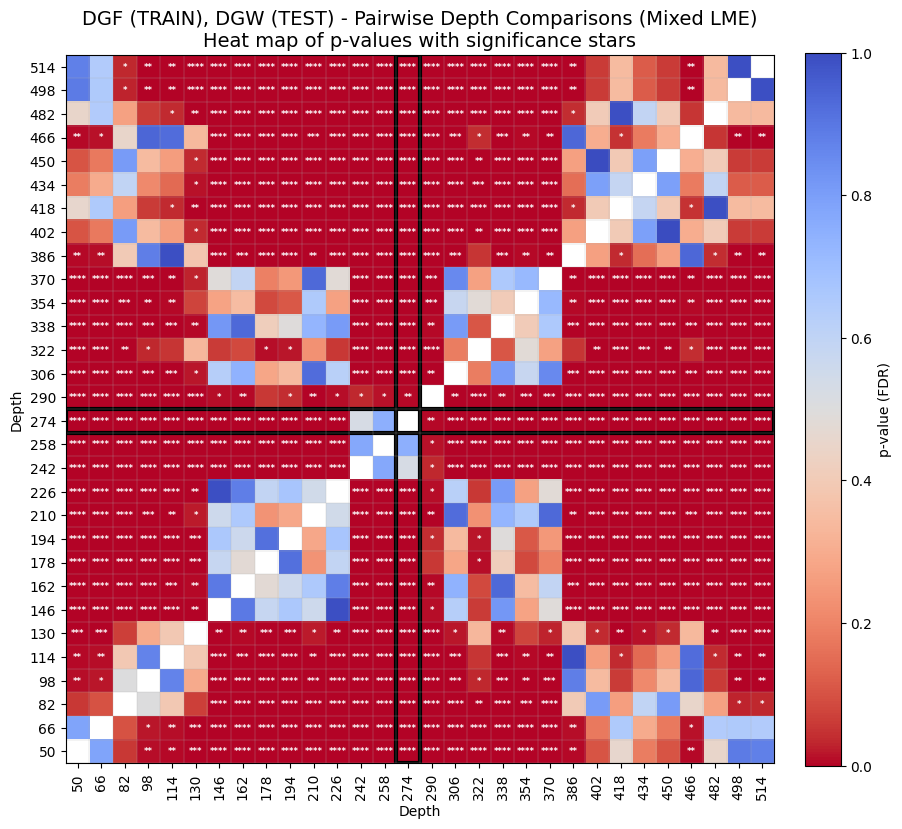

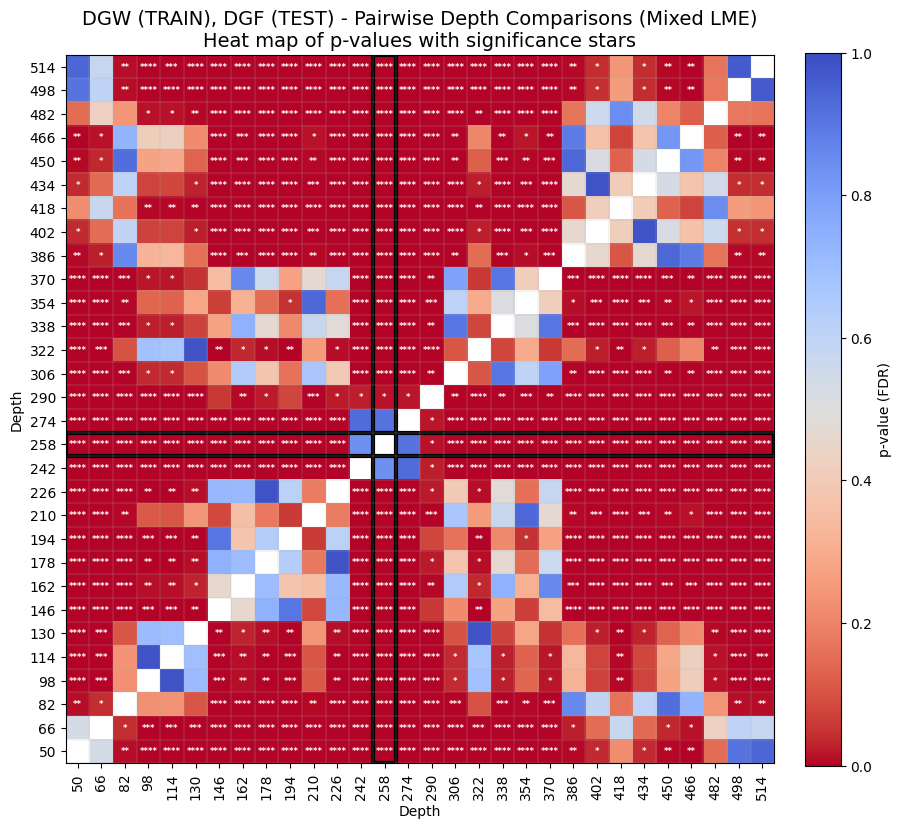

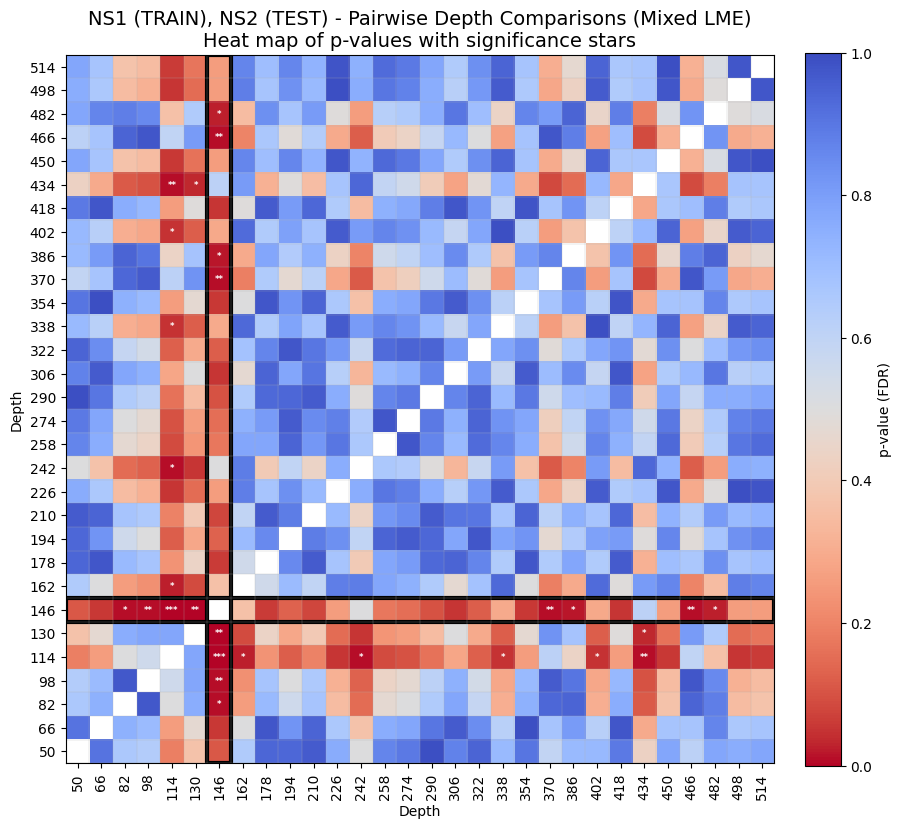

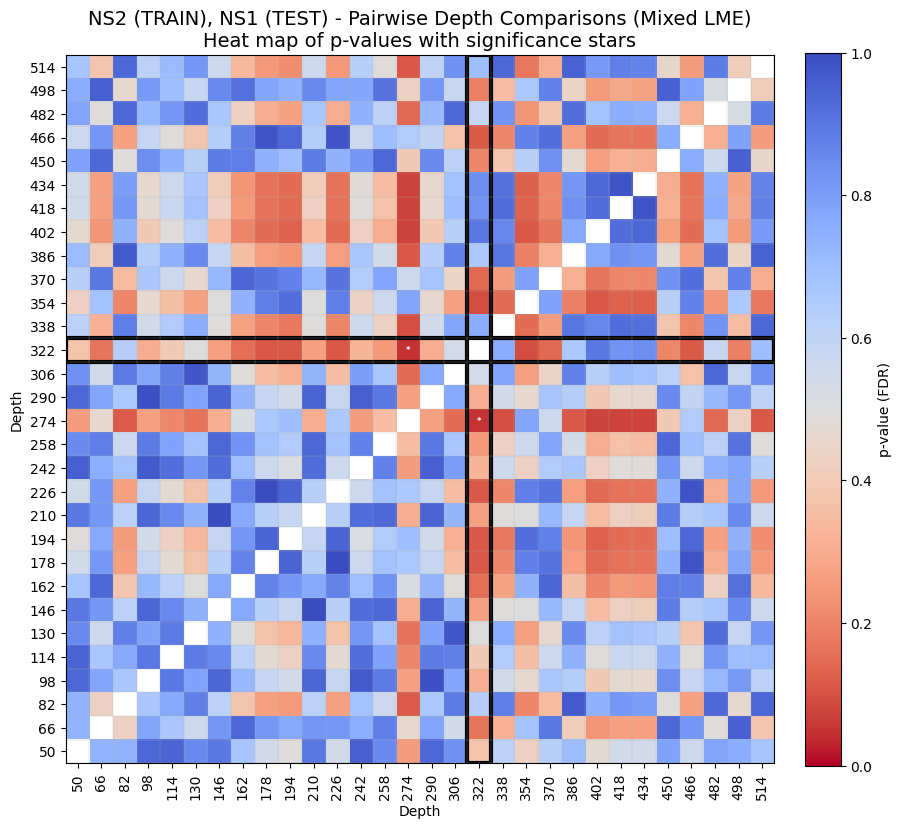

In [17]:
### Statistical testing for depth effects using mixed-effects models

titles = [
    'DGF (TRAIN), DGW (TEST)',
    'DGW (TRAIN), DGF (TEST)',
    'NS1 (TRAIN), NS2 (TEST)',
    'NS2 (TRAIN), NS1 (TEST)'
]


# fig, axs = plt.subplots(1, len(stim_types), figsize=(25, 5))
for idx, stim_type in enumerate(stim_types):
    print(f"Processing stimulus type: {stim_type}")
    sub_df = all_results_df[(all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    mean_acc_df = sub_df.explode('test_accuracy').groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth', 'stim_type_training'])['test_accuracy'].mean()
    mean_acc_df = mean_acc_df.reset_index()
    mean_acc_DGF_df = mean_acc_df[mean_acc_df['stim_type_training'] == stim_type].drop(columns=['stim_type_training'])

    df = mean_acc_DGF_df.copy()
    df = df.sort_values(by='depth').reset_index()
    df['mouse_id'] = df['mouse_id'].astype("category")
    df['column_id'] = df['column_id'].astype("category")
    df['depth'] = df['depth'].astype("category")
    depth_levels = df.depth.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        "test_accuracy ~ C(depth)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # Reduced model: no depth term (intercept only)
    res_reduced = smf.mixedlm(
        "test_accuracy ~ 1",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # Likelihood ratio test
    lr_stat = 2 * (res.llf - res_reduced.llf)
    df_diff = res.df_modelwc - res_reduced.df_modelwc
    p_value = stats.chi2.sf(lr_stat, df_diff)

    print(f"Depth effect (likelihood ratio test): χ²({int(df_diff)}) = {lr_stat:.2f}, p = {p_value:.4g}")
    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(depth)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)


    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]} - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("depth")["test_accuracy"].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG4B_statsforcrossdecoding_{titles[idx]}.png"), format="png", dpi=300)

## SUPPLEMENTARY FIGURE 4C

In [18]:
tag = "2025-08-13"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}_MatchTrials'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

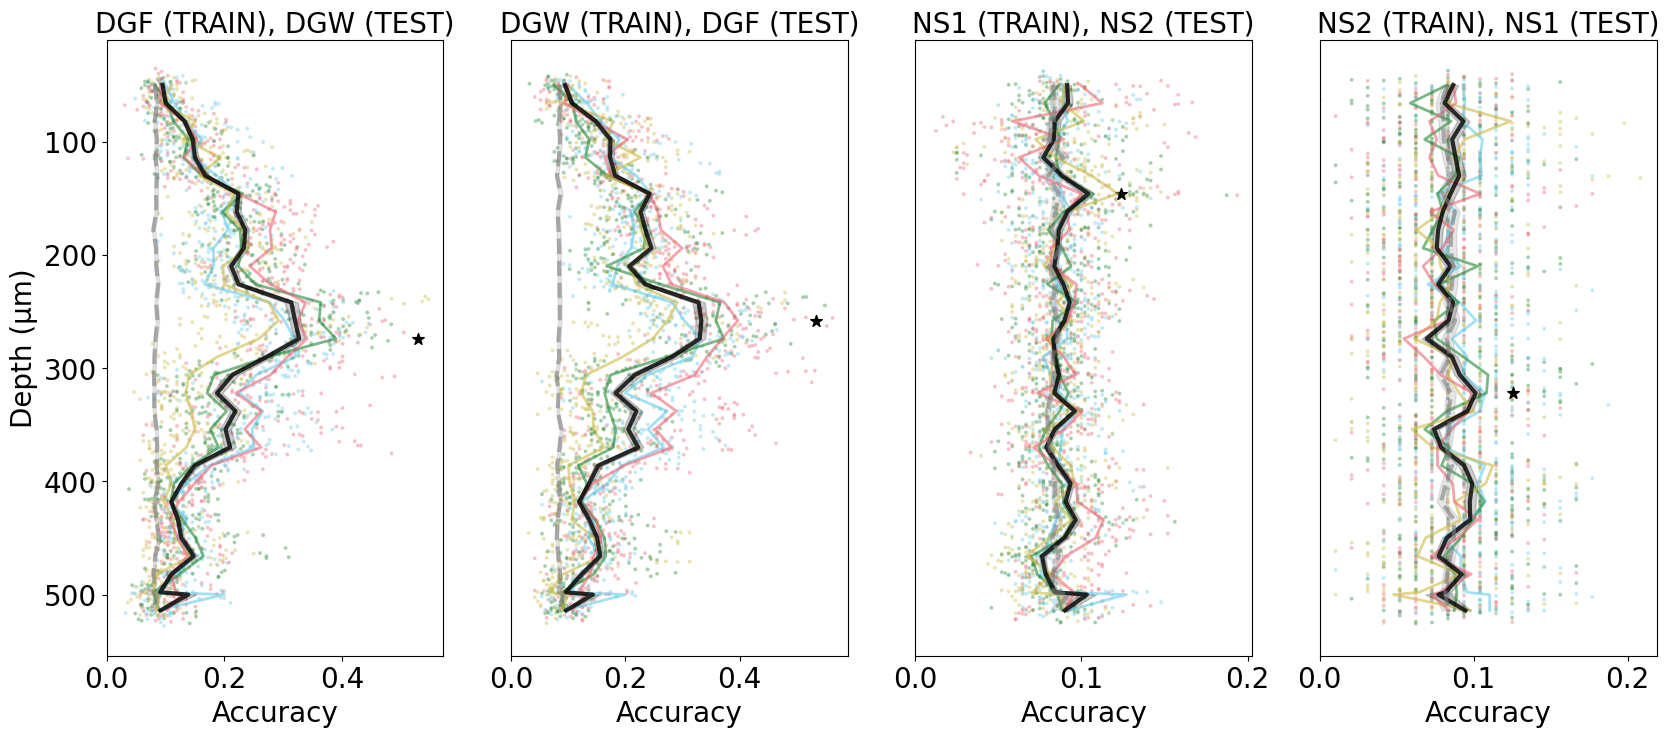

In [19]:
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
titles = [
    'DGF (TRAIN), DGW (TEST)',
    'DGW (TRAIN), DGF (TEST)',
    'NS1 (TRAIN), NS2 (TEST)',
    'NS2 (TRAIN), NS1 (TEST)'
]

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df = temp_df.explode('test_accuracy')

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False
    )

    sns.lineplot(data=temp_df, 
                    x='test_accuracy', 
                    y='depth', 
                    color='black', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    n_boot=1000, 
                    linewidth=3, 
                    alpha=0.8, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
            color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x='test_accuracy',
                    y='depth',
                    hue='mouse_id',
                    palette=mouse_colors_2,
                    s=8,
                    alpha=0.4,
                    ax=ax,
                    legend=False,
                    zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    
    sns.lineplot(data=temp_df_shuf, 
                    x='shuf_test_accuracy', 
                    y='depth', 
                    color='grey', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    linestyle='--',
                    linewidth=3, 
                    alpha=0.6, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_xlabel('Accuracy', fontsize=fontsize)
    axs[stim_idx].set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else axs[stim_idx].set_ylabel(" ")
    axs[stim_idx].set_yticks([]) if stim_idx != 0 else None
    axs[stim_idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[stim_idx].set_xlim(left=0)
    axs[stim_idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[stim_idx].invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_nobootstrapping_1plane_testaccuracies_decoding_matchtrials.svg'), dpi=300)

Processing stimulus type: drifting_gratings_full


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(29) = 304.33, p = 1.129e-47
Best depth = 274, mean accuracy = 0.327
Processing stimulus type: drifting_gratings_windowed


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(29) = 267.07, p = 2.426e-40
Best depth = 258, mean accuracy = 0.333
Processing stimulus type: natural_images
Depth effect (likelihood ratio test): χ²(29) = -199.54, p = 1


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 21.048209
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1d

Best depth = 146, mean accuracy = 0.104
Processing stimulus type: natural_images_12


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(29) = -185.82, p = 1
Best depth = 322, mean accuracy = 0.101


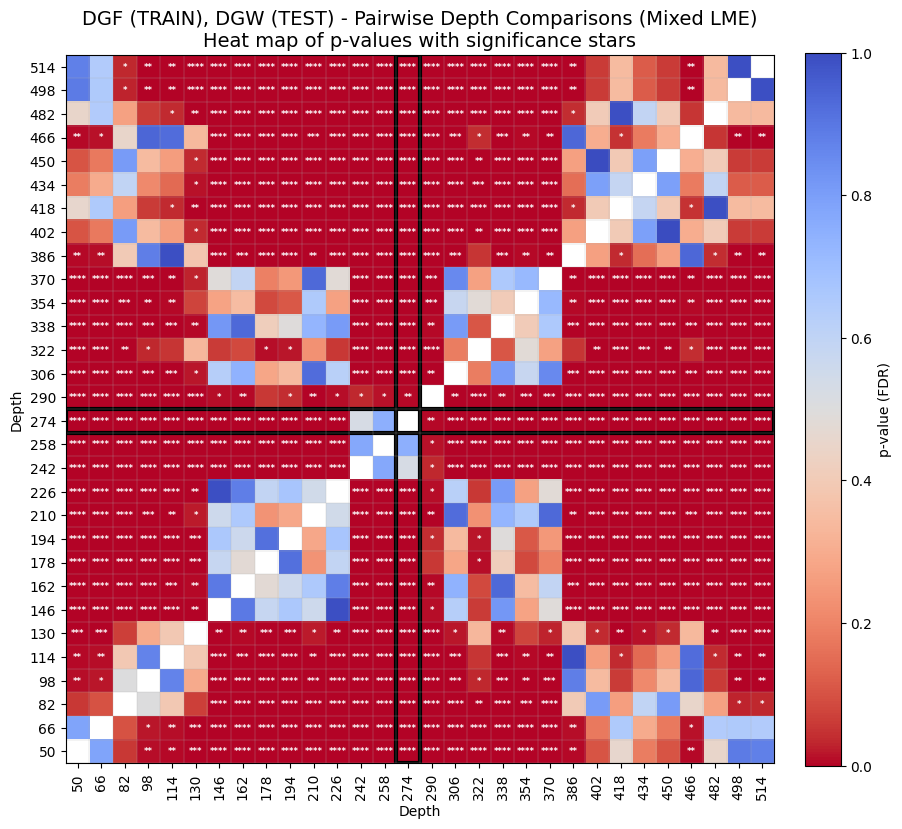

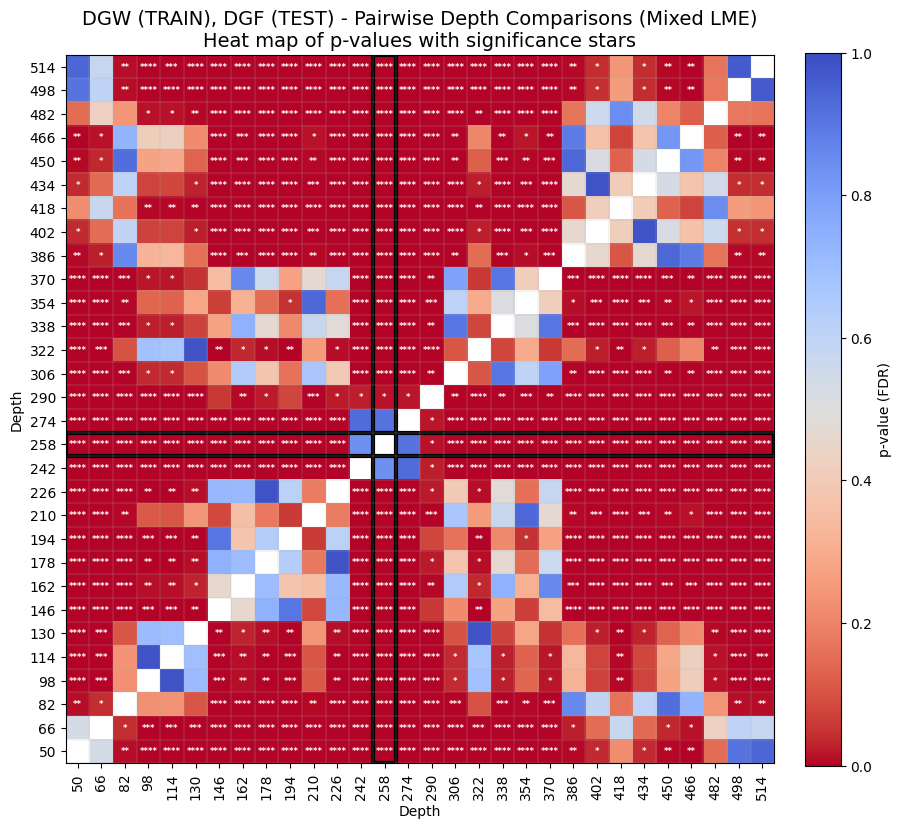

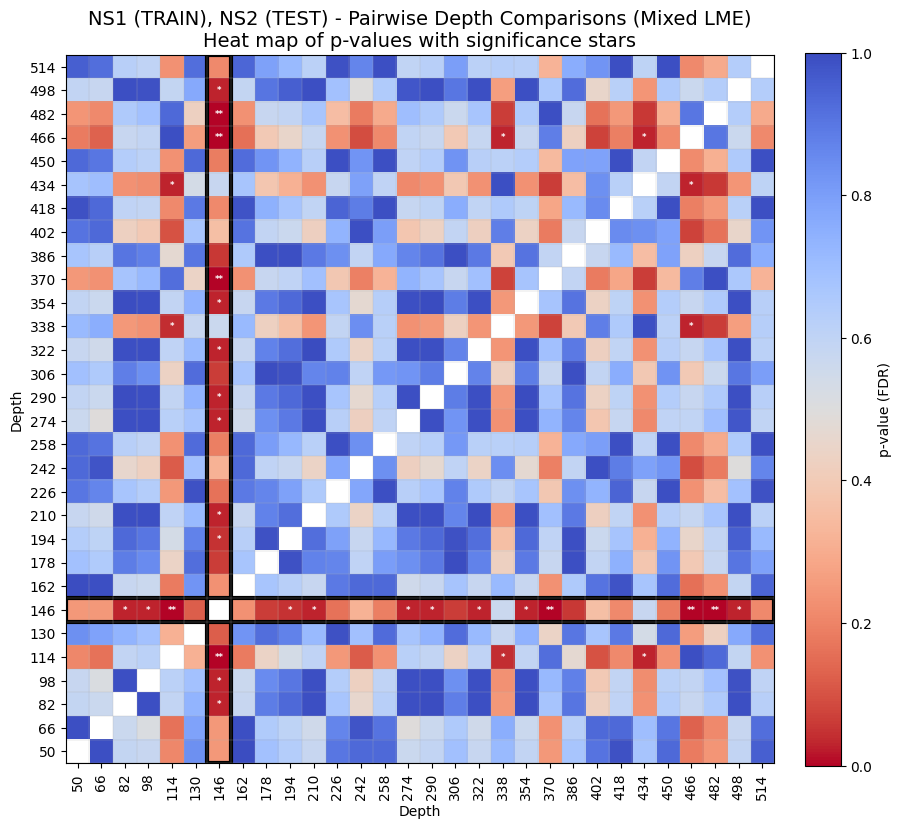

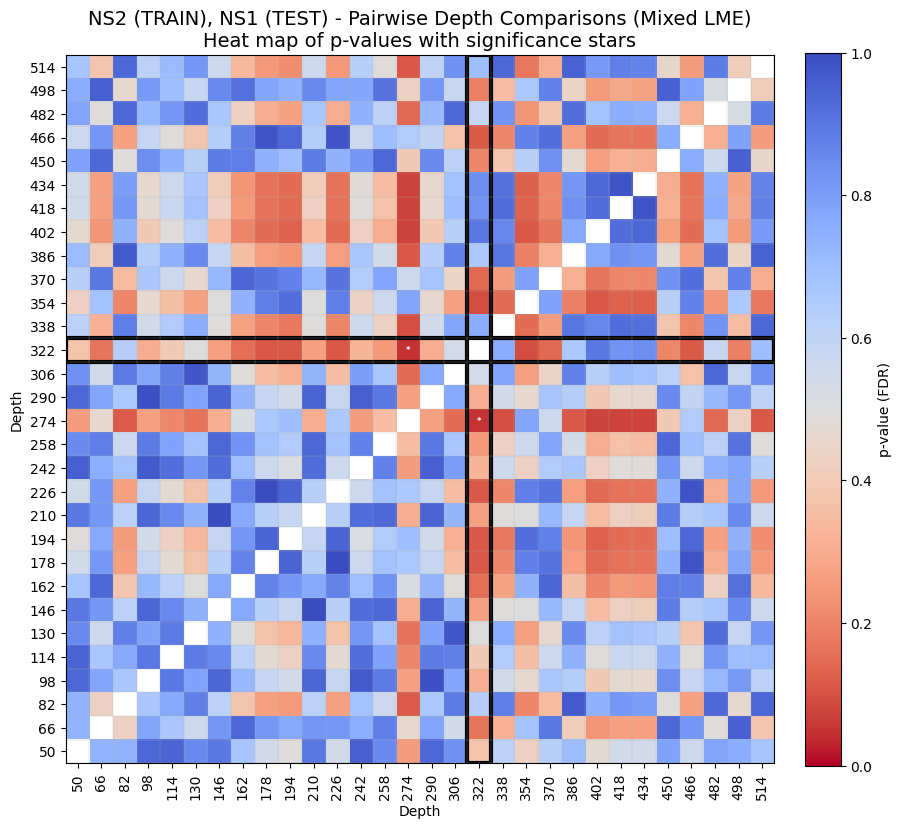

In [20]:
### Statistical testing for depth effects using mixed-effects models

titles = [
    'DGF (TRAIN), DGW (TEST)',
    'DGW (TRAIN), DGF (TEST)',
    'NS1 (TRAIN), NS2 (TEST)',
    'NS2 (TRAIN), NS1 (TEST)'
]


# fig, axs = plt.subplots(1, len(stim_types), figsize=(25, 5))
for idx, stim_type in enumerate(stim_types):
    print(f"Processing stimulus type: {stim_type}")
    sub_df = all_results_df[(all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    mean_acc_df = sub_df.explode('test_accuracy').groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth', 'stim_type_training'])['test_accuracy'].mean()
    mean_acc_df = mean_acc_df.reset_index()
    mean_acc_DGF_df = mean_acc_df[mean_acc_df['stim_type_training'] == stim_type].drop(columns=['stim_type_training'])

    df = mean_acc_DGF_df.copy()
    df = df.sort_values(by='depth').reset_index()
    df['mouse_id'] = df['mouse_id'].astype("category")
    df['column_id'] = df['column_id'].astype("category")
    df['depth'] = df['depth'].astype("category")
    depth_levels = df.depth.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        "test_accuracy ~ C(depth)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # Reduced model: no depth term (intercept only)
    res_reduced = smf.mixedlm(
        "test_accuracy ~ 1",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # Likelihood ratio test
    lr_stat = 2 * (res.llf - res_reduced.llf)
    df_diff = res.df_modelwc - res_reduced.df_modelwc
    p_value = stats.chi2.sf(lr_stat, df_diff)

    print(f"Depth effect (likelihood ratio test): χ²({int(df_diff)}) = {lr_stat:.2f}, p = {p_value:.4g}")
    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(depth)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)


    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]} - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("depth")["test_accuracy"].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG4B_statsforcrossdecoding_MATCHED_{titles[idx]}.png"), format="png", dpi=300)